# Word model

In [1]:
import numpy as np
from word_dataset import WordDataset
from word_model import WordRNN

## Dataset

In [3]:
%%time
dataset = WordDataset()
dataset.load('data/dostoevsky.txt')  # dostoevsky.txt  anna.txt
model_path = 'models/word/dostoevsky-001/'

CPU times: user 52.6 s, sys: 196 ms, total: 52.8 s
Wall time: 52.8 s


## Build

In [6]:
%%time
num_layers  = 2
num_units   = 256
grad_clip   = 5.0

model = WordRNN(
    num_classes = dataset.num_tokens)

model.build(
    emb_size   = 300,
    num_units  = num_units, 
    num_layers = num_layers, 
    grad_clip  = grad_clip)

CPU times: user 2.65 s, sys: 48 ms, total: 2.7 s
Wall time: 2.75 s


## Train

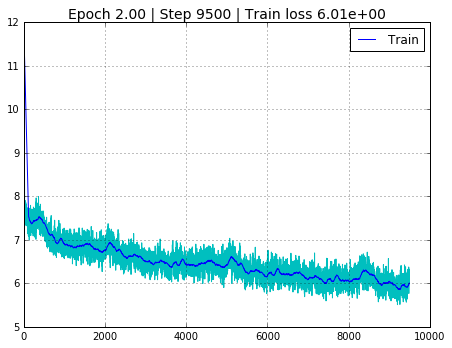

In [ ]:
%%time
model.train(
    epochs        = 50, 
    batch_size    = 32, 
    seq_length    = 20,
    learning_rate = 1e-3, 
    keep_prob     = .5,
    mean_win      = 100,
    dataset       = dataset)
model.save(model_path)

## Test

In [20]:
primes = ['поехали к']
for prime in primes:
    print('-'*50)
    samp = model.sample(dataset, n_samples=100, top_n=5, prime=prime)
    samp = samp.replace(' .', '.').replace(' ,', ',')
    print(samp)    

--------------------------------------------------
поехали к нему. я и не мог быть, и я не знаю. — а я и не могу ! — вскричал он с места. — да я и не знаю, — сказал она с каким-то улыбкой. — а ты не мог ли ? — спросил он, — да, — сказал он, — я не могу, я, кажется, в таком деле. — да я не знаю, как вы думаете : « вы, может быть, и, может быть, я не знаю. — нет, не беспокойтесь


## Restore

In [19]:
model.restore(model_path)

INFO:tensorflow:Restoring parameters from models/word/dostoevsky-001/


INFO:tensorflow:Restoring parameters from models/word/dostoevsky-001/
